In [1]:
#importing necessary python packages
import pandas as pd
import numpy as np
import os

In [2]:
# Importing the dataset
dt = pd.read_excel('Gene Clinical.xlsx',index_col=0)


In [3]:
dt.shape

(517, 15154)

In [6]:
dt.head(2)

,UBE2Q2P2,SSX9,CXORF67,EFCAB8,SDR16C6P,EFCAB12,A1BG,A1CF,RBFOX1,GGACT,...,Tissue Source Site_MN,Tissue Source Site_MP,Tissue Source Site_NJ,Tissue Source Site_O1,Tissue Source Site_S2,Person Neoplasm Status_TUMOR FREE,Person Neoplasm Status_WITH TUMOR,Vial number_A,Vial number_B,Overall Survival (Months)
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244-01,-0.4238,-0.1379,-0.1805,0.4529,-0.3317,-0.1012,-0.6977,-0.1476,-0.224,0.3832,...,0,0,0,0,0,1,0,1,0,0.00
TCGA-05-4249-01,-0.3291,-0.1379,-0.1805,-0.0869,-0.3317,-0.1661,-0.1483,-0.1371,-0.226,-0.5346,...,0,0,0,0,0,1,0,1,0,50.03


In [5]:
del dt['Column1']
del dt['Patient\'s Vital Status_Dead']
del dt['Patient\'s Vital Status_Alive']
dt.shape

(517, 15151)

In [7]:
X = dt.iloc[:,0:15150].values
y = dt.iloc[:, -1].values

In [8]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [9]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.fit_transform(X_val)

In [10]:
sc_y = StandardScaler()
y_train = np.squeeze(sc_y.fit_transform(y_train.reshape(-1, 1)))
y_val = np.squeeze(sc_y.transform(y_val.reshape(-1, 1)))
y_test = np.squeeze(sc_y.transform(y_test.reshape(-1, 1)))

In [11]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import ElasticNet
regressor = ElasticNet()


regressor.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [12]:
#Predicting the Validation set results
y_predval = regressor.predict(X_val)

In [13]:
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))



0.6216751317321926
0.709901734284034
0.8425566653252671
Variance score: 0.00


R^2 = 0.0043


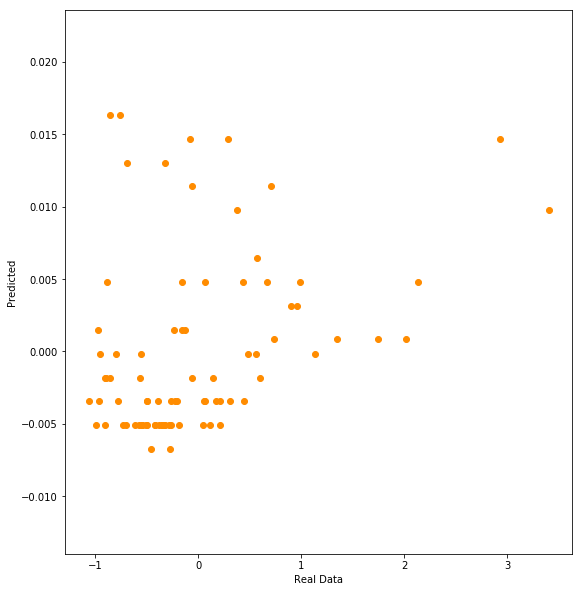

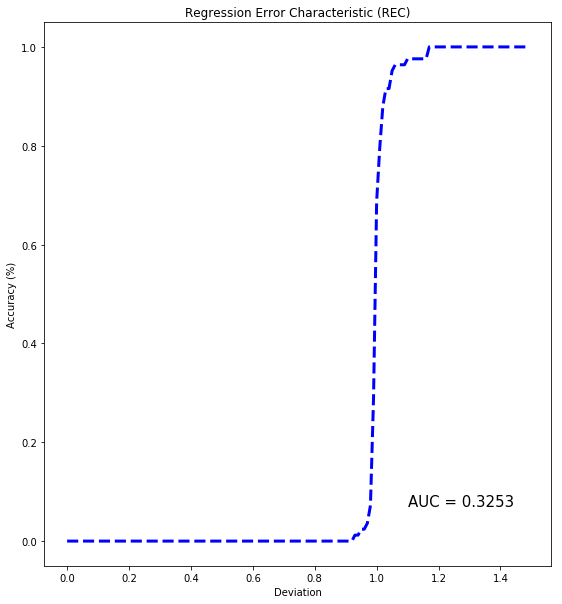

In [15]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

In [16]:
# GRID SEARCH
from sklearn.model_selection import GridSearchCV

param_grid = { 'alpha':[0.15,0.1,0.3,0.5,0.7,0.9,1.0], 'l1_ratio':[0.1,0.2,0.3,0.5,0.7,0.9,1.0],
                  "max_iter": [100,500,1000]
                  }  


In [17]:
regressor = ElasticNet()
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=10)
grid_search = grid.fit(X_train, y_train)

/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/Zayeem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did no

In [18]:
print(grid_search.best_score_, grid_search.best_params_)

0.22561254956749055 {'alpha': 0.1, 'l1_ratio': 0.7, 'max_iter': 100}


In [19]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import ElasticNet
regressor = ElasticNet(alpha= 0.1, l1_ratio = 0.7, max_iter = 100)


regressor.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=100, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [20]:
#Predicting the Validation set results
y_predval = regressor.predict(X_val)

In [21]:
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))

0.5477444402288187
0.5511434751564184
0.742390379218655
Variance score: 0.23


R^2 = 0.2269


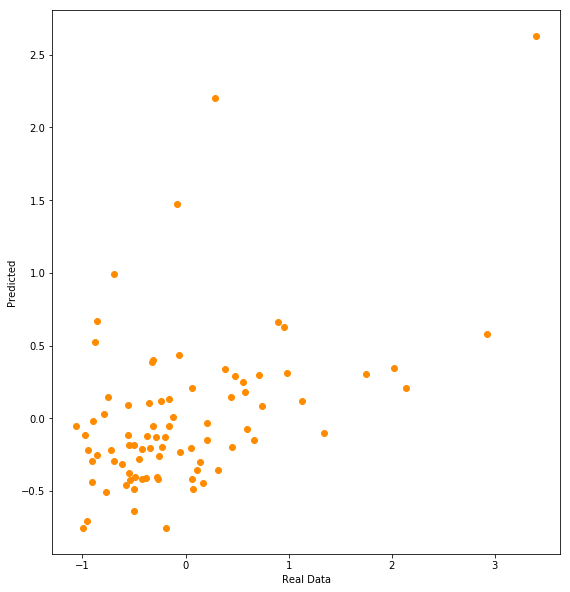

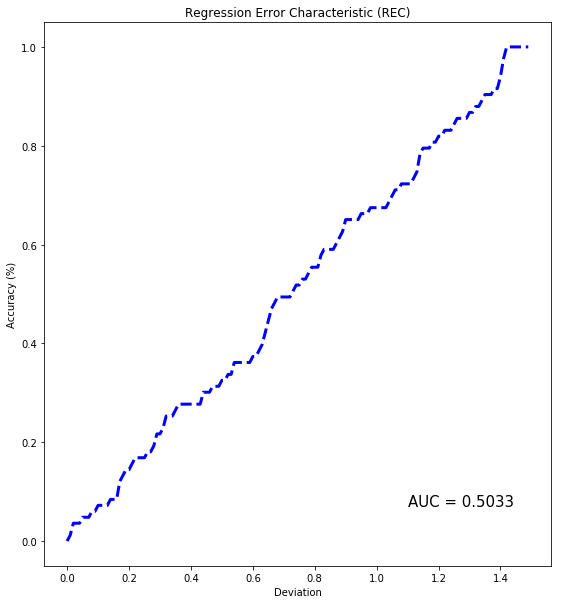

In [22]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()